In [170]:
import cv2
import numpy as np
import sys
import os
import matplotlib.pyplot as plt


def scale_frame(frame, scale):
    """
    Scales the frame.
    Args:
        frame (numpy.ndarray): The input frame.
        scale (float): The scale factor.
    Returns:
        numpy.ndarray: The scaled frame.
    """
    return cv2.resize(frame, (0, 0), fx=scale, fy=scale)

def affine_transform(frame, angle):
    """
    Applies affine transformation to the frame.
    Args:
        frame (numpy.ndarray): The input frame.
    Returns:
        numpy.ndarray: The frame with affine transformation applied.
    """
    rows, cols = frame.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(frame, M, (cols, rows))

def perspective_transform(frame,pts1,pts2):
    """
    Applies perspective transformation to the frame.
    Args:
        frame (numpy.ndarray): The input frame.
    Returns:
        numpy.ndarray: The frame with perspective transformation applied.
    """
    rows, cols = frame.shape[:2]
    
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(frame, M, (cols, rows))


def harris(frame, blockSize, ksize, k,corner_threshold=0.05):
    """
    Performs Harris corner detection on the input frame and refines the corner points.

    Parameters:
    - frame: The input frame
    - blockSize: The size of the neighbourhood considered for corner detection
    - ksize: Aperture parameter of the Sobel derivative used
    - k: Harris detector free parameter in the equation

    Returns:
    - harris_frame: The frame with highlighted Harris corners
    - refined_frame: The frame with refined corner points
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_float = np.float32(gray)

    # Apply Harris corner detection
    harris_corners = cv2.cornerHarris(gray_float, blockSize=blockSize, ksize=ksize, k=k)

    # Dilate corner image to enhance corner points
    harris_corners = cv2.dilate(harris_corners, None)

    # Threshold to mark the corners in the original image
    harris_frame = frame.copy()
    harris_frame[harris_corners > corner_threshold * harris_corners.max()] = [0, 0, 255]

    corners = np.argwhere(harris_corners > corner_threshold * harris_corners.max())


    return harris_frame, corners

def shi_tomasi(frame, maxCorners, qualityLevel, minDistance):
    """
    Performs Shi-Tomasi corner detection on the input frame and refines the corner points.

    Parameters:
    - frame: The input frame
    - maxCorners: The maximum number of corners to return
    - qualityLevel: The minimal accepted quality of image corners
    - minDistance: The minimum possible Euclidean distance between the returned corners

    Returns:
    - shi_tomasi_frame: The frame with highlighted Shi-Tomasi corners
    - refined_frame: The frame with refined corner points
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Shi-Tomasi corner detection
    corners = cv2.goodFeaturesToTrack(gray, maxCorners, qualityLevel, minDistance)
    corners = np.intp(corners)

    # Draw corners on the frame
    shi_tomasi_frame = frame.copy()
    for corner in corners:
        x, y = corner.ravel()
        cv2.circle(shi_tomasi_frame, (x, y), 3, 255, -1)

    return shi_tomasi_frame, corners

(500, 2)


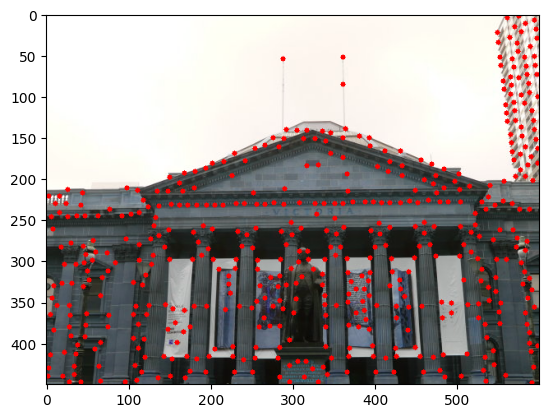

In [246]:
img1 = cv2.imread('/home/atreyabhat/RBE-ComputerVision/RBE549-NithinSanket/P1-Panorama/Phase1/Data/Train/Set1/1.jpg')
img2 = cv2.imread('/home/atreyabhat/RBE-ComputerVision/RBE549-NithinSanket/P1-Panorama/Phase1/Data/Train/Set1/2.jpg')
img3 = cv2.imread('/home/atreyabhat/RBE-ComputerVision/RBE549-NithinSanket/P1-Panorama/Phase1/Data/Train/Set1/3.jpg')

# corner_frame ,corners = harris(img1, blockSize=2, ksize=3, k=0.1)
tomasi_frame, corners = shi_tomasi(img1, maxCorners=500, qualityLevel=0.01, minDistance=10)
tomasi_corners = []

for corner in corners:
        x, y = corner.ravel()
        tomasi_corners.append([x, y])

plt.imshow(tomasi_frame)
print(np.array(tomasi_corners).shape)

In [227]:
def adaptive_non_maximal_suppression(corners, frame, N_best):

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    N = len(corners)
    r = np.full(N, np.inf)  # Initialize r with infinity

    for i in range(N):
        for j in range(N):  # Compare every pair of points
            if i != j:
                xi, yi = corners[i].ravel()
                xj, yj = corners[j].ravel()
                dist = np.linalg.norm(corners[i] - corners[j])  # Calculate distance for all pairs
                if gray_frame[int(yi), int(xi)] > gray_frame[int(yj), int(xj)] and dist < r[i]:
                    r[i] = dist

    indices = np.argsort(r)[::-1]  # Sort in descending order
    return corners[indices[:N_best]]


(100, 1, 2)


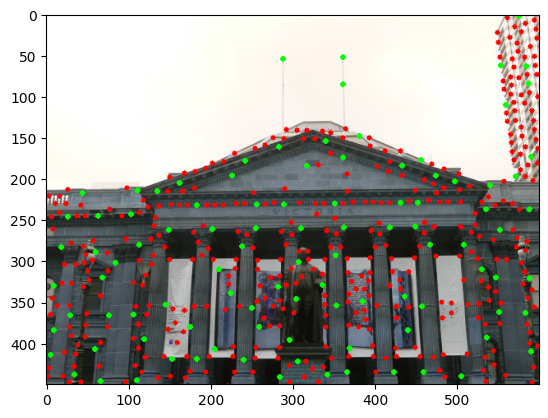

In [248]:
anms_corners = adaptive_non_maximal_suppression(corners,img1,100)
print(anms_corners.shape)

for corner in anms_corners:
    x, y = corner.ravel()
    anms_image = cv2.circle(tomasi_frame, (int(x), int(y)), 2, (0, 255, 0), 2)

plt.imshow(anms_image)

In [268]:
def extract_feature_descriptors(image, corners, patch_size=41, downsample_size=8):
    """
    Extract feature descriptors from the image at given corner points.
    :param image: Input image
    :param corners: Detected corner points
    :param patch_size: Size of the patch to extract around each corner point
    :param downsample_size: Size to downsample the patch to
    :return: List of feature descriptors
    """
    descriptors = []
    half_size = patch_size // 2
    corners = corners.ravel().reshape(-1, 2)
    new_corners = []
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    for corner in corners:
        x, y = int(corner[0]), int(corner[1])
        if x - half_size >= 0 and x + half_size < image.shape[1] and y - half_size >= 0 and y + half_size < image.shape[0]:
            patch = image[y-half_size:y+half_size+1, x-half_size:x+half_size+1]
            blurred_patch = cv2.GaussianBlur(patch, (0, 0), sigmaX=2, sigmaY=2)
            downsampled_patch = cv2.resize(blurred_patch, (downsample_size, downsample_size), interpolation=cv2.INTER_AREA)
            descriptor = downsampled_patch.flatten()
            descriptor = (descriptor - np.mean(descriptor)) / np.std(descriptor)  # Standardize
            descriptors.append(descriptor)
            new_corners.append(corner)
    
    return np.array(new_corners), np.array(descriptors)

In [271]:
kp,des = extract_feature_descriptors(img1,anms_corners,patch_size=41,downsample_size=8)


[ 0.00237748  0.45885276  1.52396174  1.67612017  1.62540069  1.47324227
  1.37180332  1.32108384 -0.80913413 -0.4540978   0.10381643  0.1545359
  0.1545359   0.05309695  0.30669433  1.32108384 -0.30193938 -0.50481728
 -0.50481728 -0.55553676 -0.50481728 -0.55553676  0.00237748  1.37180332
 -0.85985361 -0.55553676 -0.35265885 -0.30193938  0.1545359  -0.048342
  0.50957223  1.37180332 -0.65697571 -1.21488994 -1.56992627 -1.31632889
  0.1545359   0.30669433  0.91532804  1.42252279 -1.31632889 -1.51920679
 -1.62064574 -1.26560941  0.45885276  0.76316961  1.01676699  1.32108384
 -1.31632889 -1.51920679 -1.62064574 -1.11345099  0.56029171  0.76316961
  0.91532804  1.11820594 -1.21488994 -1.41776784 -1.51920679 -0.96129256
  0.50957223  0.50957223  0.76316961  1.01676699]


In [287]:
def match_features(descriptors1, descriptors2, ratio_threshold=0.7):
    """
    Match features using the ratio of the best match to the second best match.
    :param descriptors1: Feature descriptors from image 1
    :param descriptors2: Feature descriptors from image 2
    :param ratio_threshold: Threshold to keep the best match
    :return: List of matched indices
    """
    matches = []
    for i, desc1 in enumerate(descriptors1):
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        sorted_indices = np.argsort(distances)
        best_match = sorted_indices[0]
        second_best_match = sorted_indices[1]
        if distances[best_match] < ratio_threshold * distances[second_best_match]:
            matches.append((i, best_match))
    return matches


def draw_matches(img1, kp1, img2, kp2, matches):
    """
    Draw matches between two images.
    :param img1: First image
    :param kp1: Keypoints from the first image
    :param img2: Second image
    :param kp2: Keypoints from the second image
    :param matches: List of matches between keypoints
    :return: Image showing matches
    """
    # Convert keypoints to a format compatible with cv2.drawMatches
    kp1_for_draw = [cv2.KeyPoint(x=kp[0][0], y=kp[0][1], _size=1) for kp in kp1]
    kp2_for_draw = [cv2.KeyPoint(x=kp[0][0], y=kp[0][1], _size=1) for kp in kp2]

    # Draw matches
    result_img = cv2.drawMatches(img1, kp1_for_draw, img2, kp2_for_draw, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return result_img



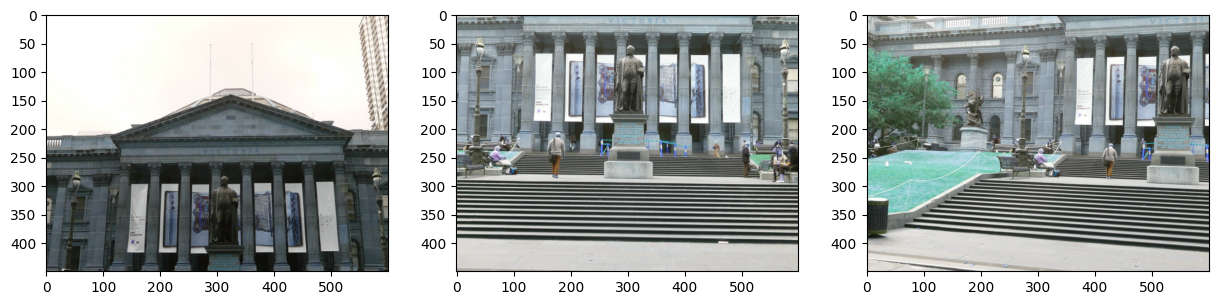

In [367]:
img1 = cv2.imread('/home/atreyabhat/RBE-ComputerVision/RBE549-NithinSanket/P1-Panorama/Phase1/Data/Train/Set1/1.jpg')
img2 = cv2.imread('/home/atreyabhat/RBE-ComputerVision/RBE549-NithinSanket/P1-Panorama/Phase1/Data/Train/Set1/2.jpg')
img3 = cv2.imread('/home/atreyabhat/RBE-ComputerVision/RBE549-NithinSanket/P1-Panorama/Phase1/Data/Train/Set1/3.jpg')

# # corner_frame ,corners = harris(img1, blockSize=2, ksize=3, k=0.1)
# _, c1 = shi_tomasi(img1, maxCorners=500, qualityLevel=0.01, minDistance=10)
# _, c2 = shi_tomasi(img2, maxCorners=500, qualityLevel=0.01, minDistance=10)
# _, c3 = shi_tomasi(img3, maxCorners=500, qualityLevel=0.01, minDistance=10)

# anms_c1 = adaptive_non_maximal_suppression(corners,img1,200)
# anms_c2 = adaptive_non_maximal_suppression(corners,img2,200)
# anms_c3 = adaptive_non_maximal_suppression(corners,img3,200)

# kp1,des1 = extract_feature_descriptors(img1,anms_corners,patch_size=41,downsample_size=8)
# kp2,des2 = extract_feature_descriptors(img2,anms_corners,patch_size=41,downsample_size=8)
# kp3,des3 = extract_feature_descriptors(img3,anms_corners,patch_size=41,downsample_size=8)

# matches12 = match_features(des1,des2)
# matches23 = match_features(des2,des3)

import matplotlib.pyplot as plt

# Plotting the first image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1)

# Plotting the second image
plt.subplot(1, 3, 2)
plt.imshow(img2)

# Plotting the third image
plt.subplot(1, 3, 3)
plt.imshow(img3)

plt.show()


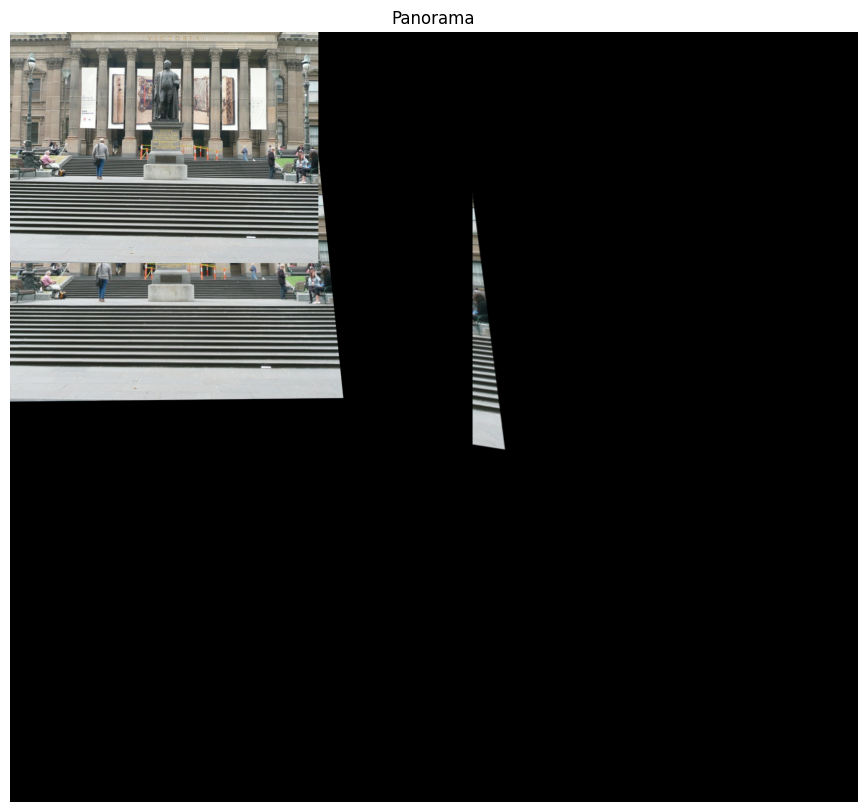

In [40]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def sift_feature_matching(img1, img2):
    # Create SIFT feature detector
    sift = cv2.SIFT_create()

    # Create FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Detect keypoints and compute descriptors using SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # Match descriptors using FLANN
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    new_matches, M = filter_matches_with_ransac(keypoints1, keypoints2, good_matches)

    result_img = custom_draw_matches(img1, keypoints1, img2, keypoints2, good_matches)

    return result_img, new_matches, M

def custom_draw_matches(img1, kp1, img2, kp2, matches):
    result_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return result_img

# Apply RANSAC for outlier rejection
def filter_matches_with_ransac(kp1, kp2, matches):
    if len(matches) < 4:
        return matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    filtered_matches = []
    for i, m in enumerate(matches):
        if mask[i]:
            filtered_matches.append(m)

    return filtered_matches, M

folder_path = '../Data/Train/Set1/'
image_files = os.listdir(folder_path)
images = []

# Load each image and append it to the list
for file_name in image_files:
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)
    images.append(image)

# Initialize the panorama with the first image
panorama = images[0]
for i in range(1, len(images)):
    img1 = panorama
    img2 = images[i]

    res_img, _,M = sift_feature_matching(img2, img1)

    # Warp the current panorama to the perspective of the next image
    panorama_warped = cv2.warpPerspective(img1,np.linalg.inv(M), (img1.shape[0] + img2.shape[0], img1.shape[1] + img2.shape[1]))

    panorama_warped[0:img1.shape[0], 0:img1.shape[1]] = img1

    # Update the panorama
    panorama = panorama_warped

# Display the final panorama
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Panorama')
plt.show()


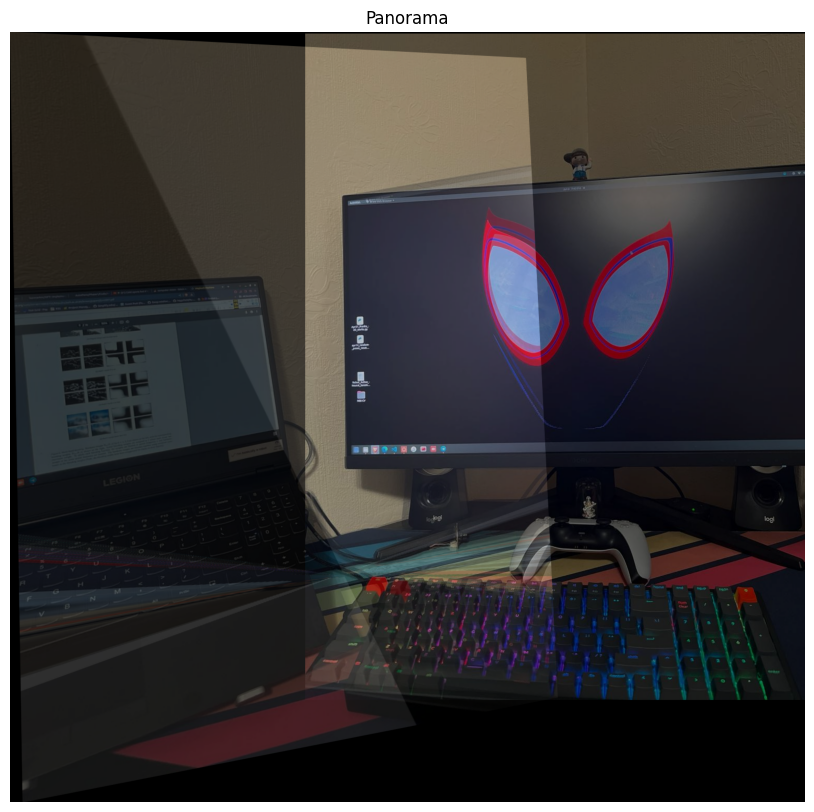

In [12]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def sift_feature_matching(img1, img2):
    # Create SIFT feature detector
    sift = cv2.SIFT_create()

    # Create FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    

    # Detect keypoints and compute descriptors using SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # Match descriptors using FLANN
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    new_matches, M = filter_matches_with_ransac(keypoints1, keypoints2, good_matches)

    result_img = custom_draw_matches(img1, keypoints1, img2, keypoints2, good_matches)

    return result_img, new_matches, M

def custom_draw_matches(img1, kp1, img2, kp2, matches):
    result_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return result_img

# Apply RANSAC for outlier rejection
def filter_matches_with_ransac(kp1, kp2, matches):
    if len(matches) < 4:
        return matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    filtered_matches = []
    for i, m in enumerate(matches):
        if mask[i]:
            filtered_matches.append(m)

    return filtered_matches, M

folder_path = '../Data/Train/CustomSet2/'
image_files = os.listdir(folder_path)
images = []

# Load each image and append it to the list
for file_name in image_files:
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)

    images.append(image)

# Initialize the panorama with the first image
panorama = images[0]
for i in range(1, len(images)):
    img1 = images[i]
    img2 = panorama

    res_img, _,M = sift_feature_matching(img2, img1)

    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]

    corner_pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    corner_pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    corner_pts2_warped = cv2.perspectiveTransform(corner_pts2, M)

    corners = np.concatenate((corner_pts1, corner_pts2_warped), axis=0)

    [xmin, ymin] = np.int32(corners.min(axis=0).ravel())
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel())

    M_shift = np.array([[1,0,-xmin],[0,1,-ymin],[0,0,1]], dtype=np.float32)
    canvas_size = (xmax-xmin, ymax-ymin)

    img1_warped = cv2.warpPerspective(img1, M_shift, canvas_size)
    img2_warped = cv2.warpPerspective(img2, M_shift.dot(M), canvas_size)

    # panorama = cv2.warpPerspective(img2, M_shift.dot(M), canvas_size, flags = cv2.INTER_LINEAR)

    # panorama[(-ymin):h1+(-ymin),(-xmin):w1+(-xmin)] = img1

    panorama = cv2.addWeighted(img1_warped, 0.5, img2_warped, 0.5, 0)

# Display the final panorama
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Panorama')
plt.show()

# plt.figure(figsize=(20, 10))
# plt.imshow(cv2.cvtColor(img1_warped, cv2.COLOR_BGR2RGB))


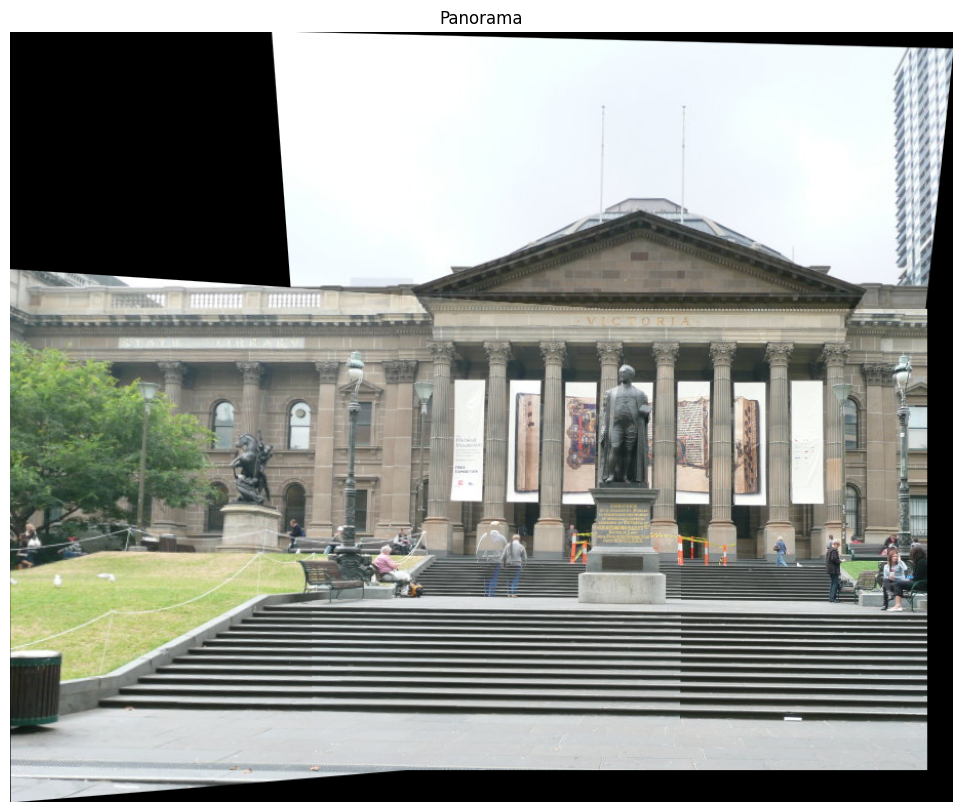

In [44]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def sift_feature_matching(img1, img2):
    sift = cv2.SIFT_create()
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    new_matches, M = filter_matches_with_ransac(keypoints1, keypoints2, good_matches)
    return new_matches, M

def filter_matches_with_ransac(kp1, kp2, matches):
    if len(matches) < 4:
        return matches, None
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    filtered_matches = [m for i, m in enumerate(matches) if mask[i]]
    return filtered_matches, M

def compute_pairwise_homographies(images):
    num_images = len(images)
    homographies = {}
    for i in range(num_images):
        for j in range(i + 1, num_images):
            _, M = sift_feature_matching(images[i], images[j])
            homographies[(i, j)] = M
            homographies[(j, i)] = np.linalg.inv(M)
    return homographies

def calculate_combined_homographies(images, anchor_index, pairwise_homographies):
    num_images = len(images)
    homographies = [None] * num_images
    homographies[anchor_index] = np.eye(3)

    def find_best_match(current_index, remaining_indices):
        best_match = None
        max_matches = 0
        best_homography = None
        for i in remaining_indices:
            matches, H = sift_feature_matching(images[current_index], images[i])
            if len(matches) > max_matches:
                max_matches = len(matches)
                best_match = i
                best_homography = H
        return best_match, best_homography

    # Find and set homographies for all images
    remaining_indices = set(range(num_images)) - {anchor_index}
    current_index = anchor_index
    while remaining_indices:
        best_match, best_homography = find_best_match(current_index, remaining_indices)
        if best_match is None:
            raise ValueError("No matches found for remaining images.")
        remaining_indices.remove(best_match)
        homographies[best_match] = homographies[current_index] @ np.linalg.inv(best_homography)
        current_index = best_match

    return homographies

def warp_images(images, homographies):
    # Determine canvas size by warping corners of all images
    corners = []
    for i, img in enumerate(images):
        h, w = img.shape[:2]
        corner_pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        corner_pts_warped = cv2.perspectiveTransform(corner_pts, homographies[i])
        corners.append(corner_pts_warped)

    corners = np.concatenate(corners, axis=0)
    [xmin, ymin] = np.int32(corners.min(axis=0).ravel())
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel())
    canvas_size = (xmax - xmin, ymax - ymin)

    # Warp each image into the canvas
    canvas = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8)
    for i, img in enumerate(images):
        M_shift = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]], dtype=np.float32)
        img_warped = cv2.warpPerspective(img, M_shift @ homographies[i], canvas_size)
        mask = (img_warped > 0).astype(np.uint8)
        canvas = np.maximum(canvas, img_warped)

    return canvas

# Load images
folder_path = '../Data/Train/Set1/'
image_files = sorted(os.listdir(folder_path))
images = [cv2.imread(os.path.join(folder_path, f)) for f in image_files]

# Define anchor image index (e.g., I1 as the anchor)
anchor_index = 1

# Compute pairwise homographies
pairwise_homographies = compute_pairwise_homographies(images)

# Calculate combined homographies relative to the anchor image
homographies = calculate_combined_homographies(images, anchor_index, pairwise_homographies)

# Warp images and create the panorama
panorama = warp_images(images, homographies)

# Display the final panorama
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Panorama')
plt.show()


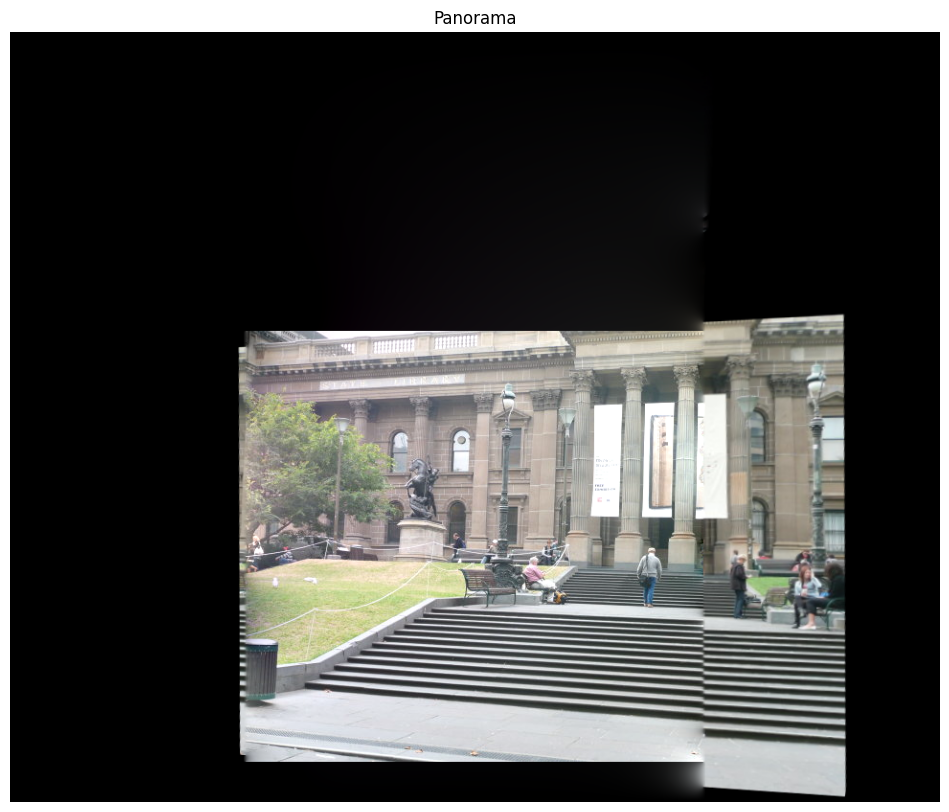

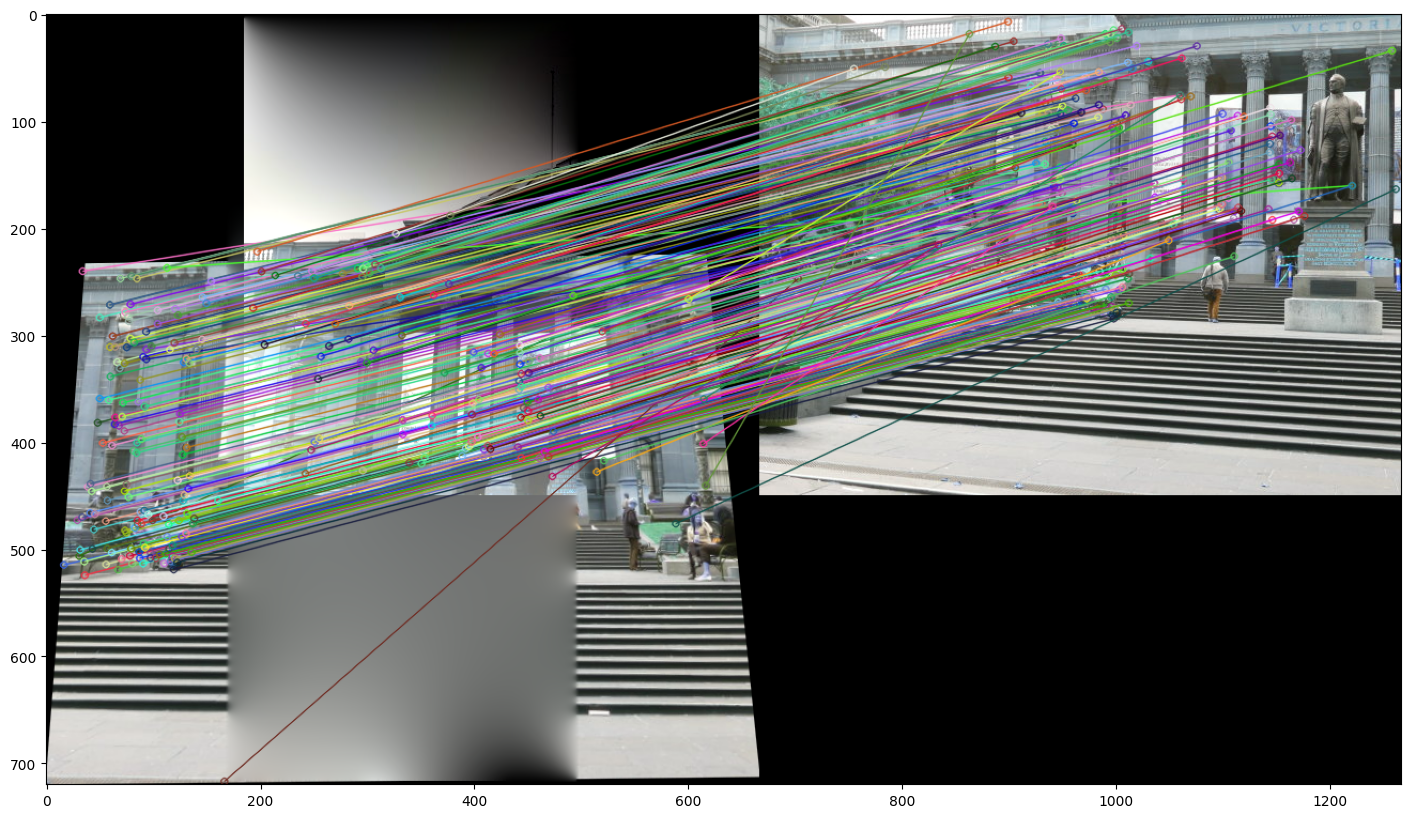

In [17]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def sift_feature_matching(img1, img2):
    # Create SIFT feature detector
    sift = cv2.SIFT_create()

    # Create FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    

    # Detect keypoints and compute descriptors using SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # Match descriptors using FLANN
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    new_matches, M = filter_matches_with_ransac(keypoints1, keypoints2, good_matches)

    result_img = custom_draw_matches(img1, keypoints1, img2, keypoints2, good_matches)

    return result_img, new_matches, M

def custom_draw_matches(img1, kp1, img2, kp2, matches):
    result_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return result_img

# Apply RANSAC for outlier rejection
def filter_matches_with_ransac(kp1, kp2, matches):
    if len(matches) < 4:
        return matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    filtered_matches = []
    for i, m in enumerate(matches):
        if mask[i]:
            filtered_matches.append(m)

    return filtered_matches, M

folder_path = '../Data/Train/Set1/'
image_files = os.listdir(folder_path)
images = []

# Load each image and append it to the list
for file_name in image_files:
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)

    images.append(image)

# Initialize the panorama with the first image
panorama = images[0]
for i in range(1, len(images)):
    img1 = images[i]
    img2 = panorama

    res_img, _, M = sift_feature_matching(img2, img1)

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corner_pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    corner_pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    corner_pts2_warped = cv2.perspectiveTransform(corner_pts2, M)

    corners = np.concatenate((corner_pts1, corner_pts2_warped), axis=0)

    [xmin, ymin] = np.int32(corners.min(axis=0).ravel())
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel())

    M_shift = np.array([[1,0,-xmin],[0,1,-ymin],[0,0,1]], dtype=np.float32)
    canvas_size = (xmax-xmin, ymax-ymin)

    img1_warped = cv2.warpPerspective(img1, M_shift, canvas_size)
    img2_warped = cv2.warpPerspective(img2, M_shift.dot(M), canvas_size)

    # Blend images using Poisson blending
    mask1 = np.zeros_like(img1_warped, dtype=np.uint8)
    mask2 = np.zeros_like(img2_warped, dtype=np.uint8)
    mask1[:, :img1_warped.shape[1]//2] = 255
    mask2[:, img1_warped.shape[1]//2:] = 255
    blended_image = cv2.seamlessClone(img1_warped, img2_warped, mask1, (img1_warped.shape[1]//2, img1_warped.shape[0]//2), cv2.NORMAL_CLONE)

    panorama = blended_image

# Display the final panorama
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Panorama')
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(res_img)
